# Deep Learning From-scratch Network Training
#### Zach Kangas
#### 5/2/22
#### Dr. Yoder
#### Deep Learning

# Introduction
In this report, we look at using the from-scratch neural network created with PyTorch to train on a linear toy dataset, then the CIFAR-10 and MNIST flattened datasets. The results from the training of each dataset is described after training, in a final validation statistic and a graph of the loss and accuracy of the training and validation sets. 

## Importing Relevant Libraries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import warnings
import os.path
import math
import seaborn as sns

import NeuralNetwork
import Client

## Setting up dtype, device, and datapaths

In [2]:
# warnings.filterwarnings('ignore')  # If you see warnings that you know you can ignore, it can be useful to enable this.

# For fashion-MNIST and similar problems
DATA_ROOT = '/data/cs3450/data/'
FASHION_MNIST_TRAINING = '/data/cs3450/data/fashion_mnist_flattened_training.npz'
FASHION_MNIST_TESTING = '/data/cs3450/data/fashion_mnist_flattened_testing.npz'
CIFAR10_TRAINING = '/data/cs3450/data/cifar10_flattened_training.npz'
CIFAR10_TESTING = '/data/cs3450/data/cifar10_flattened_testing.npz'
CIFAR100_TRAINING = '/data/cs3450/data/cifar100_flattened_training.npz'
CIFAR100_TESTING = '/data/cs3450/data/cifar100_flattened_testing.npz'

DTYPE = torch.float32
# With this block, we don't need to set device=DEVICE for every tensor.
torch.set_default_dtype(torch.float32)
if torch.cuda.is_available():
     torch.cuda.set_device(0)
     torch.set_default_tensor_type(torch.cuda.FloatTensor)
     print("Running on the GPU")
else:
     print("Running on the CPU")

Running on the GPU


## Importing training data

In [3]:
def create_linear_training_data(training_points):
    """
    This method simply rotates points in a 2D space.
    Be sure to use L2 regression in the place of the final softmax layer before testing on this
    data!
    :return: (x,y) the dataset. x is a numpy array where columns are training samples and
             y is a numpy array where columns are one-hot labels for the training sample.
    """
    x = torch.randn((2, training_points))
    x1 = x[0:1, :].clone()
    x2 = x[1:2, :]
    y = torch.cat((-x2, x1), axis=0)
    return x, y

def create_folded_training_data():
    """
    This method introduces a single non-linear fold into the sort of data created by create_linear_training_data. Be sure to REMOVE the final softmax layer before testing on this data!
    Be sure to use L2 regression in the place of the final softmax layer before testing on this
    data!
    :return: (x,y) the dataset. x is a numpy array where columns are training samples and
             y is a numpy array where columns are one-hot labels for the training sample.
    """
    x = torch.randn((2, TRAINING_POINTS))
    x1 = x[0:1, :].clone()
    x2 = x[1:2, :]
    x2 *= 2 * ((x2 > 0).float() - 0.5)
    y = torch.cat((-x2, x1), axis=0)
    return x, y


def create_square():
    """
    This is a square example
    insideness is true if the points are inside the square.
    :return: (points, insideness) the dataset. points is a 2xN array of points and insideness is true if the point is inside the square.
    """
    win_x = [2,2,3,3]
    win_y = [1,2,2,1]
    win = torch.tensor([win_x,win_y],dtype=torch.float32)
    win_rot = torch.cat((win[:,1:],win[:,0:1]),axis=1)
    t = win_rot - win # edges tangent along side of poly
    rotation = torch.tensor([[0, 1],[-1,0]],dtype=torch.float32)
    normal = rotation @ t # normal vectors to each side of poly
        # torch.matmul(rotation,t) # Same thing

    points = torch.rand((2,2000),dtype = torch.float32)
    points = 4*points

    vectors = points[:,np.newaxis,:] - win[:,:,np.newaxis] # reshape to fill origin
    insideness = (normal[:,:,np.newaxis] * vectors).sum(axis=0)
    insideness = insideness.T
    insideness = insideness > 0
    insideness = insideness.all(axis=1)
    return points, insideness


def create_patterns():
    """
    I don't remember what sort of data this generates -- Dr. Yoder

    :return: (points, insideness) the dataset. points is a 2xN array of points and insideness is true if the point is inside the square.
    """
    pattern1 = torch.tensor([[1, 0, 1, 0, 1, 0]],dtype=torch.float32).T
    pattern2 = torch.tensor([[1, 1, 1, 0, 0, 0]],dtype=torch.float32).T
    num_samples = 1000

    x = torch.zeros((pattern1.shape[0],num_samples))
    y = torch.zeros((2,num_samples))
    # TODO: Implement with shuffling instead?
    for i in range(0,num_samples):
        if torch.rand(1) > 0.5:
            x[:,i:i+1] = pattern1
            y[:,i:i+1] = torch.tensor([[0,1]],dtype=torch.float32).T
        else:
            x[:,i:i+1] = pattern2
            y[:,i:i+1] = torch.tensor([[1,0]],dtype=torch.float32).T
    return x, y


def load_dataset_flattened(train=True,dataset='Fashion-MNIST',download=False):
    """
    :param train: True for training, False for testing
    :param dataset: 'Fashion-MNIST', 'CIFAR-10', or 'CIFAR-100'
    :param download: True to download. Keep to false afterwords to avoid unneeded downloads.
    :return: (x,y) the dataset. x is a numpy array where columns are training samples and
             y is a numpy array where columns are one-hot labels for the training sample.
    """
    if dataset == 'Fashion-MNIST':
        if train:
            path = FASHION_MNIST_TRAINING
        else:
            path = FASHION_MNIST_TESTING
        num_labels = 10
    elif dataset == 'CIFAR-10':
        if train:
            path = CIFAR10_TRAINING
        else:
            path = CIFAR10_TESTING
        num_labels = 10
    elif dataset == 'CIFAR-100':
        if train:
            path = CIFAR100_TRAINING
        else:
            path = CIFAR100_TESTING
        num_labels = 100
    else:
        raise ValueError('Unknown dataset: '+str(dataset))

    if os.path.isfile(path):
        print('Loading cached flattened data for',dataset,'training' if train else 'testing')
        data = np.load(path)
        x = torch.tensor(data['x'],dtype=torch.float32)
        y = torch.tensor(data['y'],dtype=torch.float32)
        pass
    else:
        class ToTorch(object):
            """Like ToTensor, only to a numpy array"""

            def __call__(self, pic):
                return torchvision.transforms.functional.to_tensor(pic)

        if dataset == 'Fashion-MNIST':
            data = torchvision.datasets.FashionMNIST(
                root=DATA_ROOT, train=train, transform=ToTorch(), download=download)
        elif dataset == 'CIFAR-10':
            data = torchvision.datasets.CIFAR10(
                root=DATA_ROOT, train=train, transform=ToTorch(), download=download)
        elif dataset == 'CIFAR-100':
            data = torchvision.datasets.CIFAR100(
                root=DATA_ROOT, train=train, transform=ToTorch(), download=download)
        else:
            raise ValueError('This code should be unreachable because of a previous check.')
        x = torch.zeros((len(data[0][0].flatten()), len(data)),dtype=torch.float32)
        for index, image in enumerate(data):
            x[:, index] = data[index][0].flatten()
        labels = torch.tensor([sample[1] for sample in data])
        y = torch.zeros((num_labels, len(labels)), dtype=torch.float32)
        y[labels, torch.arange(len(labels))] = 1
        np.savez(path, x=x.detach().numpy(), y=y.detach().numpy())
    return x, y

# Training the Network - Linear

In this section, I use a small network to predict on the linear dataset. This really should not need any more than 3-5 nodes in the hidden layer, but I chose 10 for this example as the train time was extremely quick regardless.

In [4]:
x, y = create_linear_training_data(10000)
epochs = 10

nn = NeuralNetwork.Network(x.shape[0], y.shape[0], dtype=torch.float32, loss="l2", regularization_factor=0.01, learning_rate=0.001)
lin1 = nn.add_linear_generated(num_nodes=10, w=0.05, wo=0, b=0, bo=0, regularization=True)
rel1 = nn.add_relu()
lin2 = nn.add_linear_generated(num_nodes=2, w=0.05, wo=0, b=0, bo=0, regularization=True)


client = Client.Client(nn, x, y)
tloss, tacc = client.train_stats()
vloss, vacc = client.validation_stats()
print("E: -1", "\ttL:", tloss, "\ttA:", tacc, "\tvL:", vloss, "\tvA:", vacc)
train_data = client.train(epochs, 1, verbose=True)

E: -1 	tL: 1.9948890209197998 	tA: 0.4767500162124634 	vL: 1.882861614227295 	vA: 0.5045000314712524
E: 0 	tL: 0.0788913443684578 	tA: 0.9827500581741333 	vL: 0.06811783462762833 	vA: 0.9775000214576721
E: 1 	tL: 0.02252291329205036 	tA: 0.9888750314712524 	vL: 0.019315805286169052 	vA: 0.9900000691413879
E: 2 	tL: 0.013064330443739891 	tA: 0.9937500357627869 	vL: 0.010838055051863194 	vA: 0.9915000200271606
E: 3 	tL: 0.008565248921513557 	tA: 0.9961250424385071 	vL: 0.007008089683949947 	vA: 0.9965000748634338
E: 4 	tL: 0.006365333218127489 	tA: 0.9978750348091125 	vL: 0.005219032522290945 	vA: 0.9985000491142273
E: 5 	tL: 0.005125655326992273 	tA: 0.9982500672340393 	vL: 0.0042310841381549835 	vA: 0.9985000491142273
E: 6 	tL: 0.004361961502581835 	tA: 0.9986250400543213 	vL: 0.0036184692289680243 	vA: 0.9985000491142273
E: 7 	tL: 0.003849930362775922 	tA: 0.9987500309944153 	vL: 0.0031996257603168488 	vA: 0.9985000491142273
E: 8 	tL: 0.003465912537649274 	tA: 0.9987500309944153 	vL: 

## Statistics

**Final Training Loss\*:** 0.003

**Final Training Accuracy\*:** 0.999

**Final Validation Loss:** 0.003

**Final Validation Accuracy:** 0.999

\*: Validation and training are basically identical

### Training Graph

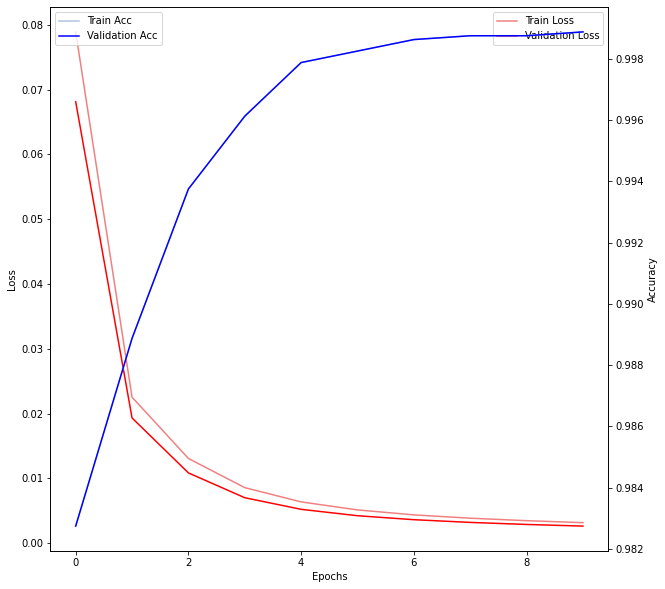

In [5]:
fig = plt.figure(figsize=(10,10))
pls = np.array(train_data)
ax = sns.lineplot(x=pls[:,0], y=pls[:,1], color="lightcoral", label="Train Loss")
ax = sns.lineplot(x=pls[:,0], y=pls[:,3], color="r", label="Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax2 = plt.twinx()
ax2.set_ylabel("Accuracy")
sns.lineplot(x=pls[:,0], y=pls[:,2], color="lightsteelblue", label="Train Acc")
sns.lineplot(x=pls[:,0], y=pls[:,2], color="b", label="Validation Acc")
plt.show()

# Training the Network - MNIST

In [6]:
dataset = 'Fashion-MNIST'

x, y = load_dataset_flattened(train=True, dataset=dataset, download=False)
epochs = 50

nn = NeuralNetwork.Network(x.shape[0], y.shape[0], loss="ce", regularization_factor=0.00001, learning_rate=0.001)
lin3 = nn.add_linear_generated(num_nodes=800, w=0.001, wo=0, b=0, bo=0, regularization=True)
rel = nn.add_relu()
lin3 = nn.add_linear_generated(num_nodes=300, w=0.0025, wo=0, b=0, bo=0, regularization=True)
rel = nn.add_relu()
lin4 = nn.add_linear_generated(num_nodes=y.shape[0], w=0.03, wo=0, b=0, bo=0, regularization=True)
nn.add_softmax()

client = Client.Client(nn, x, y)
tloss, tacc = client.train_stats()
vloss, vacc = client.validation_stats()
print("E: -1", "\ttL:", tloss, "\ttA:", tacc, "\tvL:", vloss, "\tvA:", vacc)
train_data = client.train(epochs, 1, verbose=True)

Loading cached flattened data for Fashion-MNIST training
E: -1 	tL: 2.301969289779663 	tA: 0.10106249898672104 	vL: 2.3022379875183105 	vA: 0.09574999660253525
E: 0 	tL: 1.0199207067489624 	tA: 0.6098541617393494 	vL: 1.0165126323699951 	vA: 0.6106666326522827
E: 1 	tL: 0.7970491647720337 	tA: 0.7301666736602783 	vL: 0.8024205565452576 	vA: 0.7242500185966492
E: 2 	tL: 0.6782697439193726 	tA: 0.7927708029747009 	vL: 0.6892938613891602 	vA: 0.7858332991600037
E: 3 	tL: 0.5547126531600952 	tA: 0.835979163646698 	vL: 0.5694445371627808 	vA: 0.828249990940094
E: 4 	tL: 0.5016655921936035 	tA: 0.8491041660308838 	vL: 0.520009458065033 	vA: 0.8395833373069763
E: 5 	tL: 0.4686982035636902 	tA: 0.8564791679382324 	vL: 0.49052560329437256 	vA: 0.8460000157356262
E: 6 	tL: 0.4433543384075165 	tA: 0.8630833029747009 	vL: 0.46792879700660706 	vA: 0.8528333306312561
E: 7 	tL: 0.42368823289871216 	tA: 0.867354154586792 	vL: 0.4514448046684265 	vA: 0.856249988079071
E: 8 	tL: 0.4073924124240875 	tA: 

## Statistics

**Final Training Loss:** 0.184

**Final Training Accuracy:** 0.937

**Final Validation Loss:** 0.341

**Final Validation Accuracy:** 0.883

### Training Graph

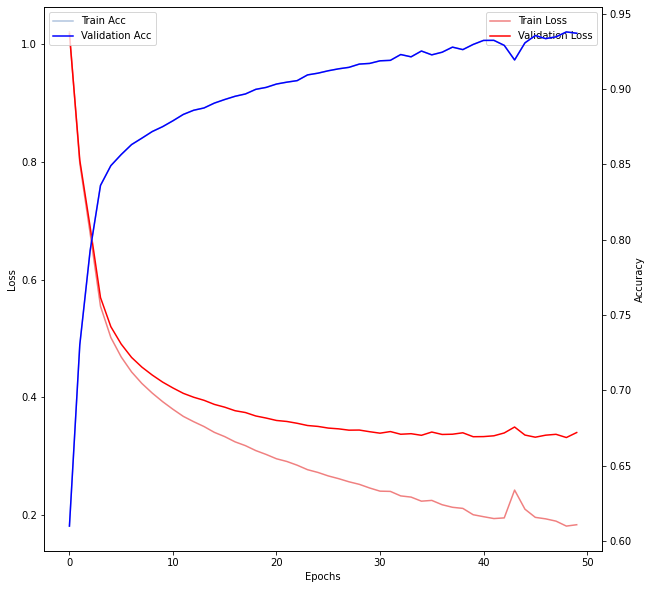

In [7]:
fig = plt.figure(figsize=(10,10))
pls = np.array(train_data)
ax = sns.lineplot(x=pls[:,0], y=pls[:,1], color="lightcoral", label="Train Loss")
ax = sns.lineplot(x=pls[:,0], y=pls[:,3], color="r", label="Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax2 = plt.twinx()
ax2.set_ylabel("Accuracy")
sns.lineplot(x=pls[:,0], y=pls[:,2], color="lightsteelblue", label="Train Acc")
sns.lineplot(x=pls[:,0], y=pls[:,2], color="b", label="Validation Acc")
plt.show()

# Training the Network - CIFAR-10

In [8]:
%%time
dataset = 'CIFAR-10'

x, y = load_dataset_flattened(train=True, dataset=dataset, download=False)
epochs = 50

nn = NeuralNetwork.Network(x.shape[0], y.shape[0], loss="ce", regularization_factor=0.0001, learning_rate=0.0002)
lin3 = nn.add_linear_generated(num_nodes=800, w=0.001, wo=0, b=0, bo=0, regularization=True)
rel = nn.add_relu()
lin3 = nn.add_linear_generated(num_nodes=300, w=0.0025, wo=0, b=0, bo=0, regularization=True)
rel = nn.add_relu()
lin4 = nn.add_linear_generated(num_nodes=y.shape[0], w=0.03, wo=0, b=0, bo=0, regularization=True)
nn.add_softmax()

client = Client.Client(nn, x, y)

tloss, tacc = client.train_stats()
vloss, vacc = client.validation_stats()
print("E: -1", "\ttL:", tloss, "\ttA:", tacc, "\tvL:", vloss, "\tvA:", vacc)
train_data = client.train(epochs, 1, verbose=True)

Loading cached flattened data for CIFAR-10 training
E: -1 	tL: 2.306262493133545 	tA: 0.10119999945163727 	vL: 2.306717872619629 	vA: 0.09519999474287033
E: 0 	tL: 2.278472900390625 	tA: 0.14217498898506165 	vL: 2.277625799179077 	vA: 0.1444000005722046
E: 1 	tL: 2.0832886695861816 	tA: 0.21222499012947083 	vL: 2.0869710445404053 	vA: 0.21359999477863312
E: 2 	tL: 2.0263068675994873 	tA: 0.2530499994754791 	vL: 2.0331838130950928 	vA: 0.25119999051094055
E: 3 	tL: 1.968971848487854 	tA: 0.2750999927520752 	vL: 1.9787909984588623 	vA: 0.2685999870300293
E: 4 	tL: 1.9420374631881714 	tA: 0.29794999957084656 	vL: 1.9531933069229126 	vA: 0.2920999825000763
E: 5 	tL: 1.9121125936508179 	tA: 0.3107749819755554 	vL: 1.924224615097046 	vA: 0.30410000681877136
E: 6 	tL: 1.8649016618728638 	tA: 0.32850000262260437 	vL: 1.8782538175582886 	vA: 0.3212999999523163
E: 7 	tL: 1.8164889812469482 	tA: 0.3481749892234802 	vL: 1.8317759037017822 	vA: 0.3409000039100647
E: 8 	tL: 1.7772924900054932 	tA: 0

## Statistics

**Final Training Loss:** 1.140

**Final Training Accuracy:** 0.586

**Final Validation Loss:** 1.43

**Final Validation Accuracy:** 0.495

### Training Graph

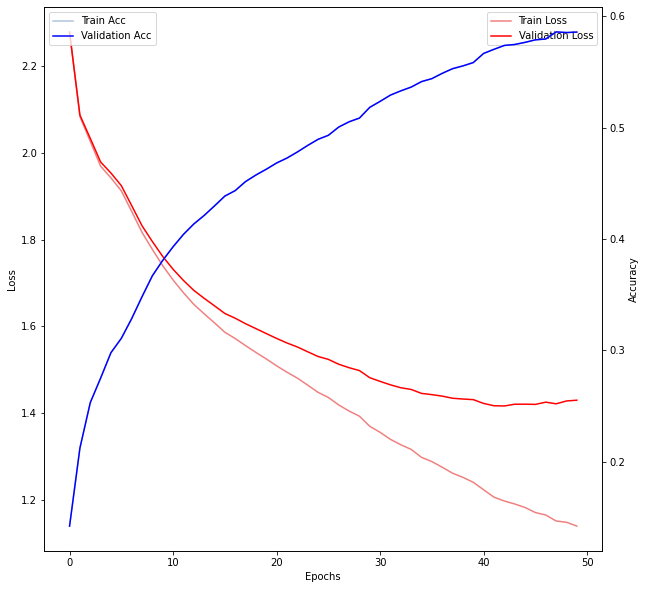

In [9]:
fig = plt.figure(figsize=(10,10))
pls = np.array(train_data)
ax = sns.lineplot(x=pls[:,0], y=pls[:,1], color="lightcoral", label="Train Loss")
ax = sns.lineplot(x=pls[:,0], y=pls[:,3], color="r", label="Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax2 = plt.twinx()
ax2.set_ylabel("Accuracy")
sns.lineplot(x=pls[:,0], y=pls[:,2], color="lightsteelblue", label="Train Acc")
sns.lineplot(x=pls[:,0], y=pls[:,2], color="b", label="Validation Acc")
plt.show()

# Reflection / Discussion

## Start of the network
The initial lab felt very odd in this series. The client, how it was suggested to be implemented, still doesn't quite make sense to me. Hence I have likely a different client implementation than most other people.

### Design Philosophy
The suggestion to manually create the layers and link them together I think in some ways was a fine one. My lab 3 I believe had basically this feature. But very quickly I struggled with modifying the layers, linking them to the output, and deciding what to do with them. So what I ended up doing was simply making a driver, in the form of the NeuralNetwork class, to handle that for me.

My gradient tape was a linked list with manual calls to the regulaization layers. This made more sense to me then doing an array, which I did in lab 3 and was one of the reasons why I thought that lab to be very tedious. 

Because of this, I certainly had obfuscated information. It would be neigh impossible to call a layer mid-inference, and difficult to show the structure of the network without just showing the code that made it.

But because the wrappers were so comprehensive in my network, it meant I can feasibly train on any dataset with any amount of layers, types of layers, and size of layers without much issue. Adding types layers is just adding the layer in layers then adding a wrapper, easy as that.

My client was basically what you'd get with a scikit learn wrapper. Train, train test split, inference, and statistics. Not much more, not much less.

## Back Prop
I thought the experience deriving the back propogation was fine. I do wish there was a little more guidance, and, moreso than guidance, specific suggestions on my original backprop that would say 'this spot is wrong or will be hard to translate due to unclear stuff.' I saw that first hand when I began unit testing, especially against pytorch's autograd, where and how some of my gradients were just minimally wrong.

More time needed to be put into a single layer backprop instead of going through the whole network in week 3-5 and calculating each layer in a sludge of information. My fist quiz on backprop I failed (9/20?) yet the second, which was a test, I think I nearly aced. It was connecting the dots from the sludge of information where providing the dots would have been more effective.

## Unit Tests
The unit tests have me split. Yes, it is good to do them. But at the same time, my unit tests I am turning in now *do not work*. It is not because my equations are wrong, but it's because I had to change a couple things from the toy unit tests to an actual training scenerio in my Network class that broke the unit tests. Could I have seen that coming, yes, but that was the case for how my implementation went.

## Final Curves
My network seems to be performing as I would expect a normal large neural network to perform. There is overfitting, yes, but the loss, both validation and training, are going down at a lessening rate each epoch. Later epochs had some odd overfitting on both datasets (CIFAR/MNIST).

## Final Notes
This series was an extremely fun, but also sometimes frustating series. The abstraction of information was made easier to debug with the unit tests, but the original design was tedious and annoying to debug as well. The backprop is not necessarily stable, but with the right starting values, results in the current training that seems to perform well. Overall, one of my favorite lab series I have run.